## 1. Download Precipitation and Isotope NEON data

In [ ]:
# Load rpy2 so R scripts can run within jupyter notebook - run this one time
%load_ext rpy2.ipython

In [ ]:
%%R 
# This rpy2 'Rmagic' command allows to run the entire cell block as R code

# Install R packages - run this one time
install.packages("neonUtilities")
install.packages('openxlsx')


In [ ]:
%%R

# Load required libraries - run this every time
library(neonUtilities)
library(openxlsx)

# Download and export ONAQ isotope data --> change this to all sites??
ONAQIsoData <- loadByProduct(dpID="DP1.00038.001", site=c("ONAQ"))
list2env(ONAQIsoData, .GlobalEnv)
write.xlsx(wdi_isoPerSample, "~/Desktop/NEON/Temporal_Downscaling_NEON_Pisotopes/ONAQIsoData.xlsx", row.names=F)

# downloading and exporting ONAQ precipitation data
ONAQPrecipData <- loadByProduct(dpID="DP1.00006.001", site=c("ONAQ"))
list2env(ONAQPrecipData, .GlobalEnv)
write.xlsx(PRIPRE_30min, "~/Desktop/NEON/Temporal_Downscaling_NEON_Pisotopes/ONAQPrecipData.xlsx", row.names=F)

## 2. Generate a downscaled daily data product at each NEON site

In [1]:
## Python Import Statements
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt

ROOTDIR = os.getcwd() # Home directory
CODEDIR = ROOTDIR + '/CODE/' # Code directory
DATADIR = ROOTDIR + '/DATA/' # Data directory

os.chdir(CODEDIR) # Change directory
import changeTimes
import getRunningMean
import conditional_copula_ts
import iso_sine_signal
import calcSiteStats

os.chdir(ROOTDIR) # Change directory

In [2]:
# 30min Precipitation Data
df_P30 = pd.read_excel(DATADIR+'/PrecipData/ONAQPrecipData.xlsx',index=False)
df_P30 = changeTimes.change_Pdata(df_P30)


# Sum to Daily Precipitation Amounts
df_P30b = df_P30.set_index('DateTime')
precip_daily = df_P30b['priPrecipBulk'].resample('D').sum() # sum total daily P
frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
daily_P['Total P'].replace(0, np.nan, inplace=True)


# Biweekly Stable Water Isotope Data
df_iso = pd.read_excel(DATADIR+'/IsoData/ONAQIsoData.xlsx',index=False)
df_iso = changeTimes.change_ISOdata(df_iso)



# Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

P14 = []
for i in np.arange(len(df_iso['setDate'])):
    subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
            & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))
    
    df_sub = df_P30.loc[subset]
    P14.append(np.nansum(df_sub['priPrecipBulk'].values))

df_iso['Total P'] = P14
del P14, i, subset

Step 1 - Remove seasonal time series component (Section 2.b.1)

In [12]:
# Define Sine Wave Functions
df_iso = df_iso.sort_values('DateTime')
df_iso = df_iso.dropna(subset=['Total P'])
tsX = df_iso['FracYear'].values 
tsP = df_iso['Total P'].values
tsO = df_iso['d18OWater'].values
tsH = df_iso['d2HWater'].values   

dayslist = []
for dt in np.arange(len(df_iso['DateTime'])):
    dayslist.append((df_iso['DateTime'].iloc[dt] - df_iso['DateTime'].iloc[0]).days)
dayslist = np.array(dayslist)

# this is precipitation frequency (see Eq. 4)
p_events = df_iso[df_iso['Total P'].notna()]

lamda = len(p_events['Total P'])/((daily_P.index.max() - daily_P.index.min()).days) 
print("lambda = ",lamda)

sitename = str((df_iso['sampleID'].iloc[0])[4:8])

params1, params2 = iso_sine_signal.sine_params(sitename,14,tsX,tsP,tsH,tsO) # 14 = biweekly sample, sample frequency
tsY_sine_wave = iso_sine_signal.sine_func(tsX, params1[0],params1[1],params1[2]) # solve for amplitude, phase, offset
adj_2H = np.array((tsH - tsY_sine_wave))    # remove seasonality from time series                       

tsY_sine_wave = iso_sine_signal.sine_func(tsX, params2[0],params2[1],params2[2])     
adj_18O = np.array((tsO - tsY_sine_wave))  

lambda =  0.02203856749311295


In [4]:
# Get biweekly site stats of stochastic component
biweekly_stats = np.array([[np.mean(tsP), np.mean(adj_2H), np.mean(adj_18O)],
                 [np.std(tsP), np.std(adj_2H), np.std(adj_18O)],
                 [sp.stats.pearsonr(tsP,adj_2H)[0], sp.stats.pearsonr(tsP,adj_18O)[0], sp.stats.pearsonr(adj_2H,adj_18O)[0]]])
print("Resulting time series statistics should be a mean zero process - means are approx. zero")
print(biweekly_stats)

Resulting time series statistics should be a mean zero process - means are approx. zero
[[ 1.00729167e+01 -6.41625064e-09  4.10853063e-09]
 [ 6.25405167e+00  2.40001063e+01  4.21709252e+00]
 [-2.74446363e-01 -5.11704193e-01  8.43321290e-01]]


Step 2 - Predict daily statistics from biweekly time series (Section 2.b.2)
Now we will need to aggregate the stochastic biweekly time series - i.e. calculated
weighed running means at biweekly (14-day), 28-day, 42-day, 56-day and 84-day intervals

In [5]:
# function defining calculated statistics on time series
site_stats = [[sitename, 14, lamda,
               biweekly_stats[0,0], biweekly_stats[0,1], biweekly_stats[0,2],
               biweekly_stats[1,0], biweekly_stats[1,1], biweekly_stats[1,2],
               biweekly_stats[2,0], biweekly_stats[2,1], biweekly_stats[2,2]]]

for n in np.arange(28,85,14):
    xday_Hb, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsH),np.array(tsP),tsX,n)
    xday_Ob, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsO),np.array(tsP),tsX,n)  

    xday_Xb = np.array(xday_Xb)
    xday_Pb = np.array(xday_Pb)
    xday_Hb = np.array(xday_Hb)
    xday_Ob = np.array(xday_Ob)   
  
    params1a, params2a = iso_sine_signal.sine_params(sitename,n,xday_Xb,xday_Pb,xday_Hb,xday_Ob)

    tsY_sine_wave = iso_sine_signal.sine_func(xday_Xb, params1a[0],params1a[1],params1a[2])
    adj_2Hb = np.array((xday_Hb - tsY_sine_wave))                           

    tsY_sine_wave = iso_sine_signal.sine_func(xday_Xb, params2a[0],params2a[1],params2a[2])     
    adj_18Ob = np.array((xday_Ob - tsY_sine_wave))   
    
    calcSiteStats.main(site_stats,sitename,lamda,n,xday_Pb,adj_2Hb,adj_18Ob)
 
### the stats are labeled with 'B' here because they are of the stochastic component - not the original time series
Site_Stats = pd.DataFrame(site_stats, columns = ['site','agglev','lambda','PmuB','HmuB','OmuB','PsigB','HsigB','OsigB','PHpB','POpB','HOpB'])
print(Site_Stats)

   site  agglev    lambda       PmuB          HmuB          OmuB     PsigB  \
0  ONAQ      14  0.022039  10.072917 -6.416251e-09  4.108531e-09  6.254052   
1  ONAQ      28  0.022039  10.867179  5.086557e-11  1.274495e-11  3.318060   
2  ONAQ      42  0.022039  10.538750 -5.490219e-08  3.563882e-09  2.803673   
3  ONAQ      56  0.022039  10.232938  3.055387e-10  5.886917e-09  3.757364   
4  ONAQ      70  0.022039  10.645119  2.297601e-08 -4.139117e-09  3.063283   
5  ONAQ      84  0.022039  10.271329  3.794298e-13  2.756906e-13  2.388358   

       HsigB     OsigB      PHpB      POpB      HOpB  
0  24.000106  4.217093 -0.274446 -0.511704  0.843321  
1  20.984352  2.839854 -0.111215 -0.299670  0.926102  
2  21.377732  3.022917 -0.612062 -0.601064  0.988039  
3  19.167251  2.665483  0.196506  0.119621  0.968970  
4  24.172918  2.957074  0.088320  0.054249  0.992629  
5  22.424191  3.107741  0.100196  0.100158  1.000000  


In [6]:
### Now we apply equation 4
Hi = [] ; Oi = [] # estimated 1-day parameters
H_a = [] ; O_a = [] # a term

xaxis = np.array(Site_Stats['agglev'].values)
yaxis1 = np.array(Site_Stats['HsigB'].values)
yaxis2 = np.array(Site_Stats['OsigB'].values)

def eq4(x,a,b):
    return b/(x*lamda)**a

bounds = [[0.25,yaxis1[0]],[0.5,np.inf]]
p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis1, p0 = [0.3,yaxis1[0]], bounds=bounds)

Hi.append(float(p1[1]))
H_a.append(p1[0])

bounds = [[0.2,yaxis2[0]],[0.5,np.inf]]
p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis2,  p0 = [0.3,yaxis2[0]], bounds=bounds)

Oi.append(float(p1[1]))
O_a.append(p1[0])

Step 3 - Generate daily time series with estimated statistcs (Section 2.b.2)

In [7]:
H_scale = np.sort(np.array(adj_2H) * Hi / Site_Stats['HsigB'].iloc[0])
O_scale = np.sort(np.array(adj_18O) * Oi / Site_Stats['OsigB'].iloc[0])

copula_stats = np.matrix([[0, 0, 0], [np.std(tsP), Hi, Oi],
                          [Site_Stats['PHpB'].iloc[0], Site_Stats['POpB'].iloc[0],
                           Site_Stats['HOpB'].iloc[0]]])    
        
new_ts = conditional_copula_ts.main(daily_P['Total P'],copula_stats,H_scale,O_scale)
y = np.array([np.array(xi) for xi in new_ts])

Step 4 - Add in seasonal time series component (Section 2.b.2)

(array([736573., 736695., 736815., 736938., 737060., 737180., 737303.,
        737425., 737546.]),
 <a list of 9 Text xticklabel objects>)

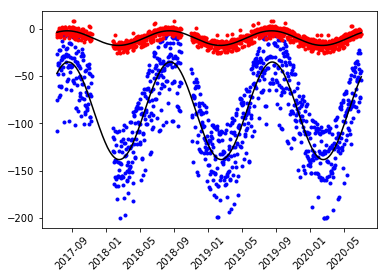

In [8]:
# Add back in n-day sine function here:
tsH_daily = y[:,0] + iso_sine_signal.sine_func(daily_P['FracYear'], params1[0],params1[1],params1[2])    
tsO_daily = y[:,1] + iso_sine_signal.sine_func(daily_P['FracYear'], params2[0],params2[1],params2[2])

daily_P['d2H'] = tsH_daily
daily_P['d18O'] = tsO_daily 

plt.figure()
plt.plot(daily_P.index, daily_P['d2H'],'b.')
plt.plot(daily_P.index, iso_sine_signal.sine_func(daily_P['FracYear'], params1[0],params1[1],params1[2]),'k')
plt.plot(daily_P.index, daily_P['d18O'],'r.')
plt.plot(daily_P.index, iso_sine_signal.sine_func(daily_P['FracYear'], params2[0],params2[1],params2[2]),'k') 
plt.xticks(rotation=45)
plt.savefig(ROOTDIR+'/FIGURES/'+str(sitename)+'_iso.png',dpi=20)

## 3. visualize output - i.e. time series plots and dual isotope plots

In [ ]:
# python or R scripts for plotting 1-2 sites (user can interchange site plotted by using unique site code (4 letter string))